In [164]:
#imports
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import datetime as dt
import patsy
import multiprocessing as mp

import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.ensemble as ensemble

from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from IPython.display import display

In [165]:
# Notebook Settings
pd.set_option('display.max_columns', 50)
pd.set_option('precision', 4)
%matplotlib inline
from __future__ import print_function
from __future__ import division

In [166]:
# read data
y_df = pd.read_csv(
    '../../data/water_pump/training_labels.csv', header=0)

X_df = pd.read_csv(
    '../../data/water_pump/training.csv', header=0,
    parse_dates=['date_recorded'])
X_df = X_df.merge(y_df, on='id')

#training_labels_df = pd.read_csv(training_labels_file)
#training_values_df = pd.read_csv(training_values_file)

#training_values_df['status_group'] = training_labels_df['status_group']

In [167]:
X_df.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
48409,35966,3000.0,2013-01-22,Government Of Tanzania,1158,DWE,30.2579,-4.6131,Kwa Ndundulu,0,Lake Tanganyika,Nyenge Kati,Kigoma,16,2,Kasulu,Titye,378,True,GeoData Consultants Ltd,Water authority,Mbagwe,True,1986,gravity,gravity,gravity,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
13110,62752,0.0,2012-10-19,Dwe,0,DWE,33.0080,-4.0759,Sumbu,0,Internal,Sumbu,Tabora,14,1,Nzega,Kasela,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
14944,18843,0.0,2012-10-21,Dwsp,0,DWSP,33.3076,-3.8522,Kwa Rashid Seif,0,Internal,Sambali,Shinyanga,17,3,Shinyanga Rural,Usanda,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional
21510,36374,0.0,2012-10-31,Tlc,0,TLC,32.0726,-5.1161,Ibrahim Kagete,0,Lake Tanganyika,Imalamakoye B,Tabora,14,4,Urambo,Imalamakoye,0,True,GeoData Consultants Ltd,Private operator,NaN,True,0,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
26212,8035,2000.0,2011-02-28,Institution,239,Wa,38.3887,-6.3326,Zahanati Msata,0,Wami / Ruvu,Barabarani,Pwani,6,1,Bagamoyo,Msata,5,True,GeoData Consultants Ltd,WUA,Chalinze wate,True,2003,ksb,submersible,submersible,parastatal,parastatal,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


In [168]:
X_df['months_old'] = X_df.date_recorded.apply(
    lambda x: (dt.datetime.today() - x).days // 30)


In [169]:
X_df.drop(['wpt_name', 'num_private', 'recorded_by','date_recorded'],
          axis=1, inplace=True)

In [170]:
X_df.public_meeting = X_df.public_meeting.astype('float')
X_df.permit = X_df.permit.astype('float')
X_df.status_group.replace(
    {'non functional': 1, 'functional needs repair' :2,'functional': 3},
    inplace=True
    )

In [171]:
cols = list(X_df.columns)
cols_numeric = cols.copy()
for col in cols:
    if X_df[col].dtype == 'int':
        X_df[col] *= 1.0
    if X_df[col].dtype =='object':
        X_df[col].replace({'unknown': np.nan}, inplace=True)
        #print('\n',col,'====\n', X_df[col].unique())
        cols_numeric.remove(col)
    
#     if X_df[col].dtype =='object':
#         a = X_df[col].unique()
#         X_df[col].replace( a, np.arange(1, a.shape[0] + 1), inplace=True)



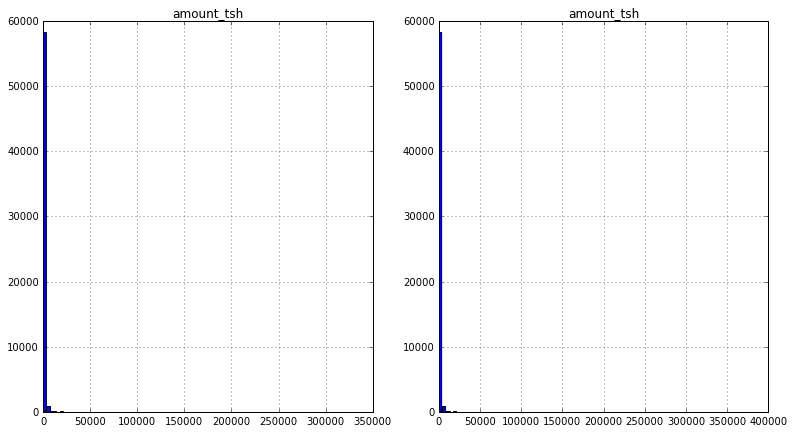

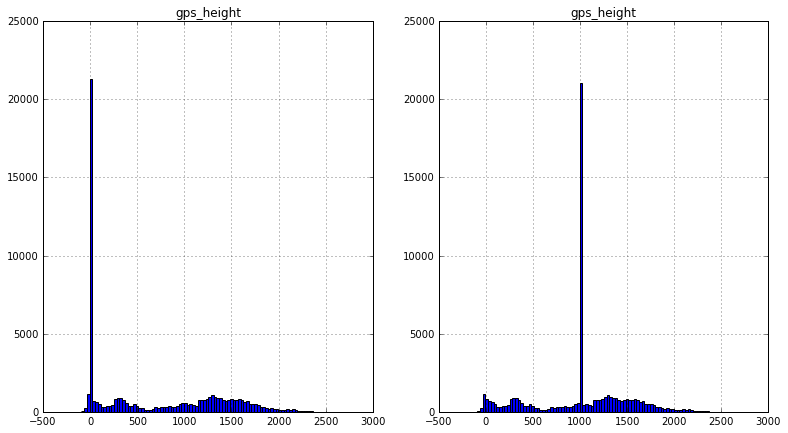

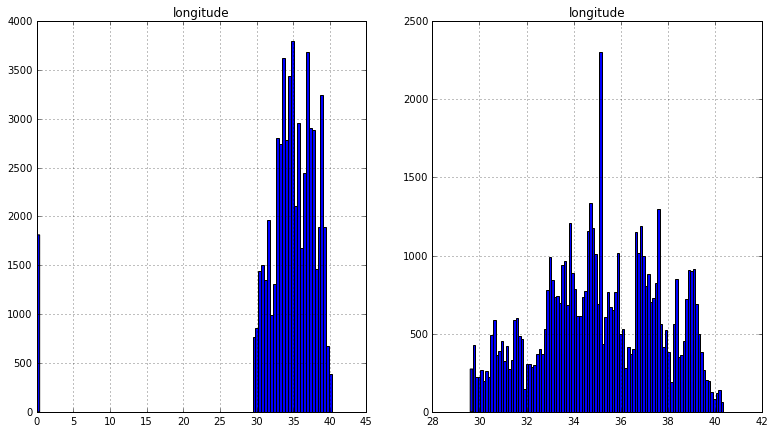

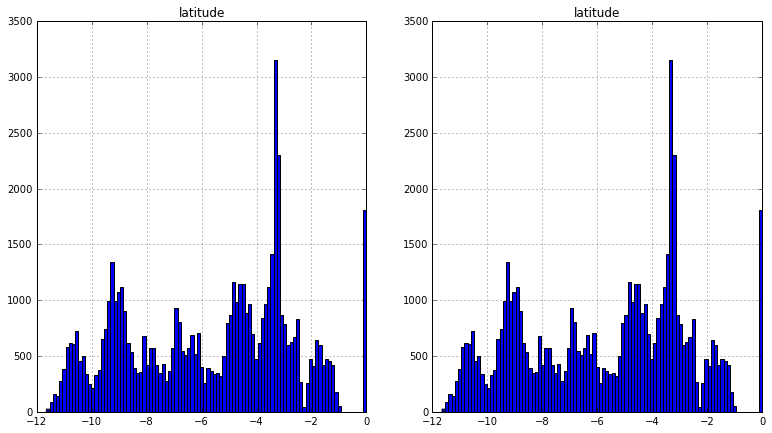

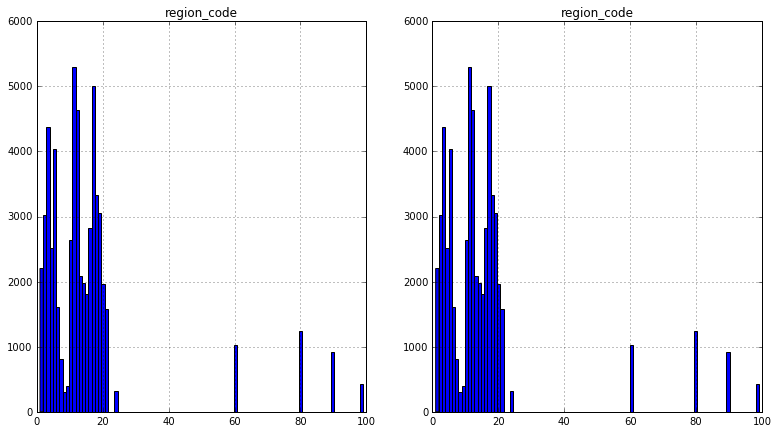

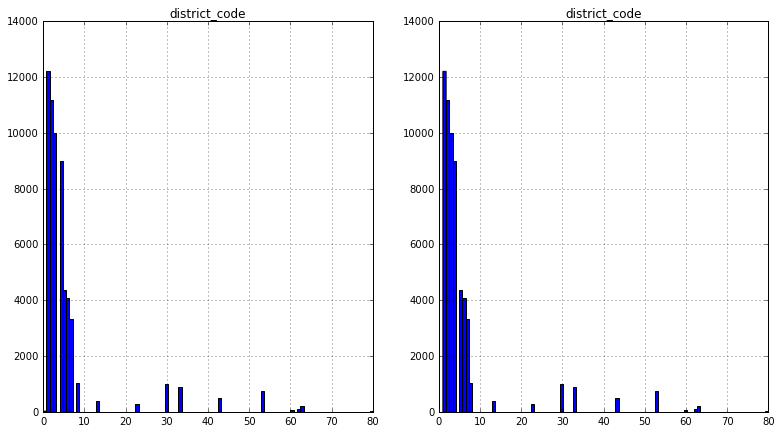

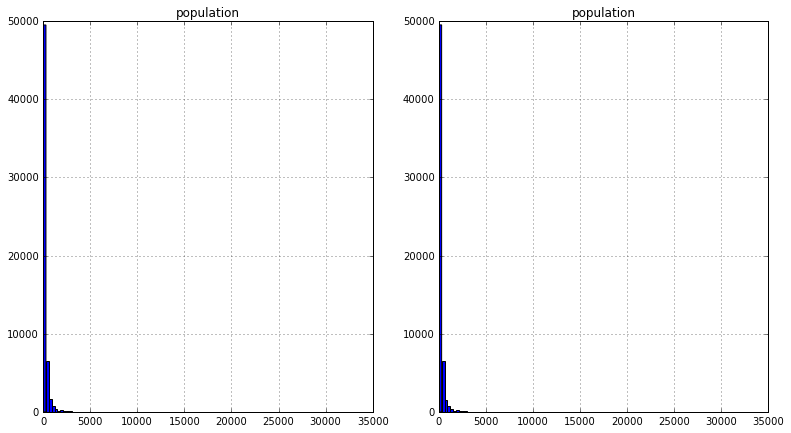

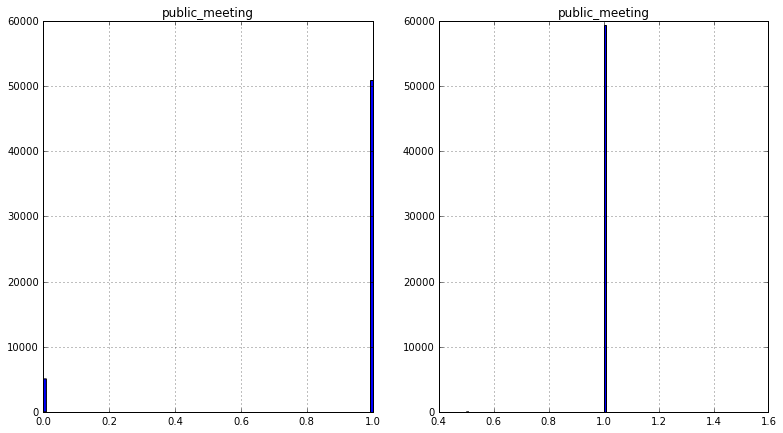

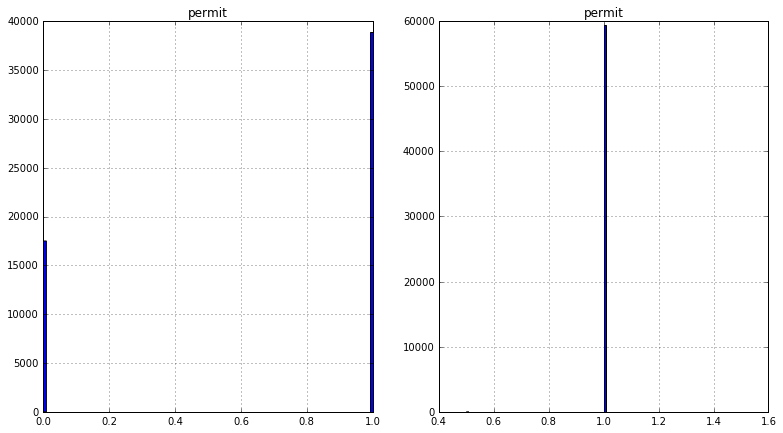

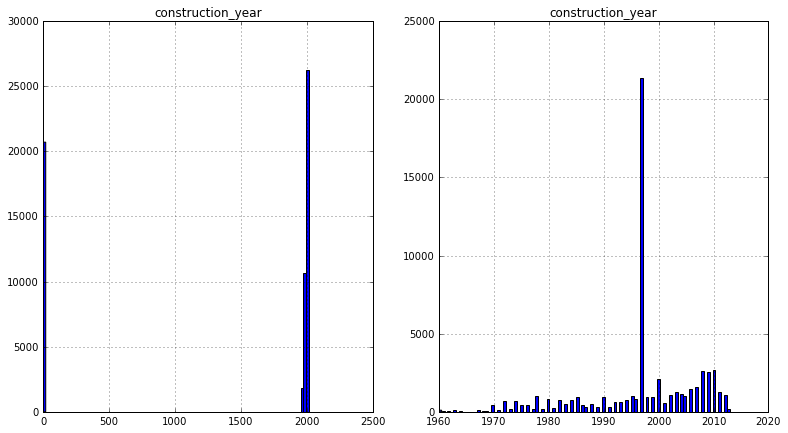

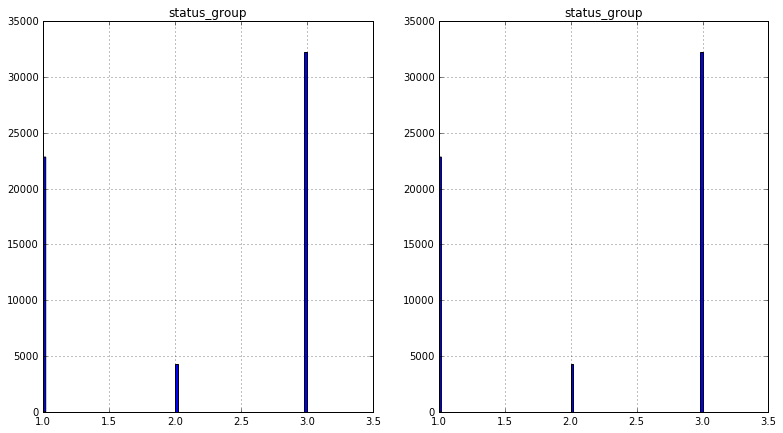

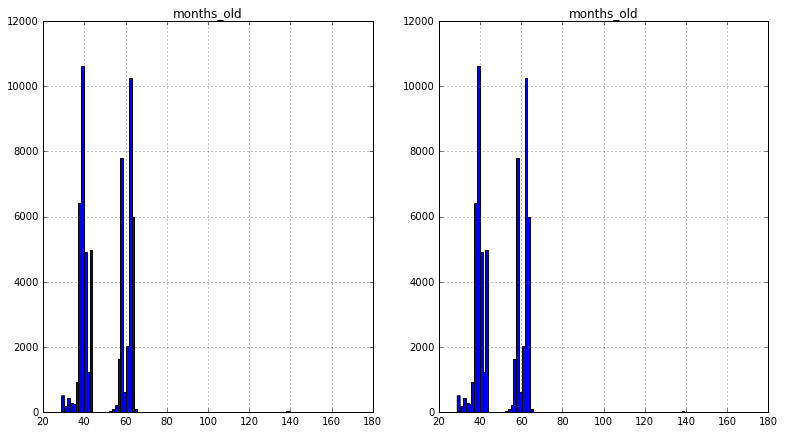

In [156]:
for col in cols_numeric[1:]:
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize =(13,7))
    X_df[col].hist(bins=100,ax = ax1)
    ax1.set_title(col)
    
    X_df[col].replace({0: np.nan}, inplace=True)
    X_df[col] = X_df[col].fillna(X_df[col].mean())
    
    X_df[col].hist(bins=100,ax = ax2)
    ax2.set_title(col)

# Run classification algorithms

In [172]:
print(X_df[cols_numeric].shape, X_df[cols_numeric].dropna().shape)

(59400, 13) (53281, 13)


In [173]:
X_df = X_df.dropna()
y = X_df.status_group.values
X = X_df[cols_numeric].values 

# #cat_list = ['quantity','district_code','scheme_management','extraction_type_group','water_quality','basin']
# cat_list = ['quantity','district_code','scheme_management','extraction_type_group','basin']

# for cat_feature in cat_list:
#     temp_df = pd.get_dummies(training_values_df[cat_feature])
#     X_df = X_df.join(temp_df)
# X_df.sample(5)

In [174]:
# cleaning
# construction_mean = X_df[X_df.construction_year>0].mean()
# X_df['construction_year'].replace(0, construction_mean)

# pop_mean = X_df[X_df.population > 0].mean()
# X_df['population'].replace(0,pop_mean)

# gps_height_mean = X_df[X_df.gps_height>0].mean();
# X_df['gps_height'].replace(0,gps_height_mean);

In [175]:
# split training/test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [176]:
# run classification algorithms
clf = linear_model.LogisticRegressionCV(scoring='accuracy',
                                         cv=5, n_jobs=4, Cs=8)
y_hat = clf.fit(X_train, y_train).predict(X_test)
print( "Accuracy with logistic regression = %4.4f" %
      metrics.accuracy_score(y_test, y_hat))

Accuracy with logistic regression = 0.9261


In [162]:
naive_b = GaussianNB()
y_predict_naive_b = naive_b.fit(X_train,y_train).predict(X_test)
print( "Accuracy with Naive Bayes = %4.4f " %
      metrics.accuracy_score(y_test,y_predict_naive_b))

Accuracy with Naive Bayes = 0.8972 


In [163]:
d_tree = DecisionTreeClassifier()
y_predict_d_tree = d_tree.fit(X_train,y_train).predict(X_test)

print("Accuracy with Decision Tree = %4.4f" %
      accuracy_score(y_test,y_predict_d_tree))

NameError: name 'accuracy_score' is not defined

In [ ]:
grid = {'max_depth': [3, 4, 5, 6],
        'n_estimators': [40, 50, 60,  100]
       }
clf = GridSearchCV(RandomForestClassifier(), n_jobs=4,
                   param_grid=grid,
                   scoring='f1_micro', cv=8)

#clf.fit(X_train, y_train)
y_hat = clf.fit(X_train,y_train).predict(X_test)

print('Best Params: \n', clf.best_params_ )
print("Accuracy with Random Forest = %4.4f"  %
      accuracy_score(y_test, y_hat))

In [ ]:
m = metrics.confusion_matrix(y_test, y_hat)
print(m)
m[:, 1] = m[:,1:].sum(axis=1)
m[1, :] = m[1:,:].sum(axis=0)

m = m[:2, :2]
print(m)

In [ ]:
# commenting out for now since it takes too long
grid = {'C': 10 ** np.arange(-3, 4,0.5), 'gamma': 10 ** np.arange(-2.5, 2)}

clf = GridSearchCV(SVC(),n_jobs=3, param_grid=grid, scoring='f1_micro',cv=5)

# clf.fit(X_train, y_train)
# y_hat = clf.predict(X_test)
# # print("Accuracy with SVM = %4.4f" %
#       accuracy_score(y_test, y_hat))

In [ ]:
from sklearn.metrics import confusion_matrix
# get y_pred and y_actual
y_pred = model.predict(X_test)
#convert y's to binaryconf_matrix = confusion_matrix(y_actual, y_pred)confusion_matrix[1,:] = confusion_matrix[:, 1:2].sum()
y_actual = y_test

np.